# This notebook provides a simulation of the burgers equation both in DNS and LES modes, 

In [1]:
#/usr/bin/env python
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint as odeintTorch

# 1) Direct Numerical Simulation (DNS)

In [2]:
# input settings DNS solution
nx   = 200 # nx DNS
mp   = int(nx/2)
dx   = 1/nx # dx DNS
x_discr = np.arange(0,1,dx)
visc    = 0.001
damp    = 0
L_t     = 2.5#s
dt      = 0.001
nt      = int(L_t/dt)
Time_sampling = torch.from_numpy(np.linspace(0,L_t,nt+1)).float()

The burgers equation and (most importantly its solver) are implemented in pytorch to make easy the implementation of end-to-end closure models

In [3]:
class BurgersModel(torch.nn.Module):
    
    def __init__(self):
        super(BurgersModel, self).__init__()
    def filterDown(self,u,k):
        # signal shape information
        n   = int(u.shape[-1])
        m   = int(n/k)
        l   = int(m/2)
        # compute fft then filter
        fu  = torch.fft.fft(u)
        fuf = torch.zeros((u.shape[0],u.shape[1],m),dtype=torch.complex64)
        fuf[:,:,0:l]   = fu[:,:,0:l]
        fuf[:,:,l+1:]  = fu[:,:,n-l:]
        # return from spectral space
        uf = (1/k)*torch.real(torch.fft.ifft(fuf))
        return uf                
    def derivative(self,u,dx):
        
        # signal shape information
        n = int(u.shape[-1])
        m = int(n/2)
        
        # Fourier colocation method
        h       = 2*np.pi/n
        fac     = h/dx
        k       = torch.fft.fftfreq(n,d=1/n)
        k[m]    = 0
        fu      = torch.fft.fft(u)
        
        dudx    = fac*torch.real(torch.fft.ifft(1J*k*fu))
        d2udx2  = fac**2 * torch.real(torch.fft.ifft(-k*k*fu))
        d3udx3  = fac**3 * torch.real(torch.fft.ifft(-1J*k**3*fu))
        
        # dealiasing needed for du2dx using zero-padding 
        zeroPad = torch.zeros((fu.shape[0],n))#.reshape(1,-1)
        fu_p    = torch.cat((fu[:,:m],zeroPad,fu[:,m:]),dim = -1)
        u_p     = torch.real(torch.fft.ifft(fu_p))        
        u2_p    = u_p**2
        fu2_p   = torch.fft.fft(u2_p)
        fu2     = fu2_p[:,0:m]
        fu2     = torch.cat((fu2,fu2_p[:,n+m:]),dim = -1)
        du2dx   = 2*fac*torch.real(torch.fft.ifft(1J*k*fu2))

        # store derivatives in a dictionary for selective access
        derivatives = {
            'dudx'  :   dudx,
            'du2dx' :   du2dx,
            'd2udx2':   d2udx2,
            'd3udx3':   d3udx3
        }
        
        return derivatives
    
    def forward(self,u,time,dx,visc):
        
        def burg_system(t,u,dx=dx,visc=visc):
            # compute derivatives
            u[:,0] = u[:,-1] = 0.
            derivs = self.derivative(u,dx)
            du2dx  = derivs['du2dx']
            d2udx2 = derivs['d2udx2'] 
            du2dx[:,0] = du2dx[:,-1] = 0.
            d2udx2[:,0] = d2udx2[:,-1] = 0.
            rhs = visc * d2udx2 - 0.5*du2dx 
            return rhs
        sol = odeintTorch(burg_system, u, time, method = 'rk4')#, mxstep=5000)
        return sol
Burgers_Torch = BurgersModel()

In [4]:
# Initial conditions :
initu = []
for RE in range(100,1000,100):
    t0 = np.exp(RE/8)
    initu.append(torch.from_numpy(x_discr/(1+np.sqrt(1/t0)*np.exp(RE*x_discr**2/4))).float())#.unsqueeze(0)
initu = torch.stack(initu)

In [5]:
# DNS solution !
sol_DNS = Burgers_Torch(initu,Time_sampling,dx,visc)

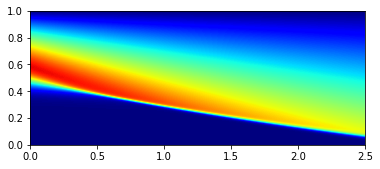

In [6]:
extent=[0,2.5,0,1]
plt.imshow(sol_DNS[:,0,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)

# 2) Large Eddy Simulation (LES), on a coarse grid 

In [7]:
# input settings LES solution
nxLES   = 25 # nx LES
mpLES   = int(nxLES/2)
dxLES   = 1/nxLES # dx LES
x_discrLES = np.arange(0,1,dxLES)
scale = int(nx/nxLES)

In [8]:
inituLES = []
for RE in range(100,1000,100):
    t0 = np.exp(RE/8)
    inituLES.append(torch.from_numpy(x_discrLES/(1+np.sqrt(1/t0)*np.exp(RE*x_discrLES**2/4))).float())#.unsqueeze(0)
inituLES = torch.stack(inituLES)

In [9]:
sol_LES = Burgers_Torch(inituLES,Time_sampling,dxLES,visc)

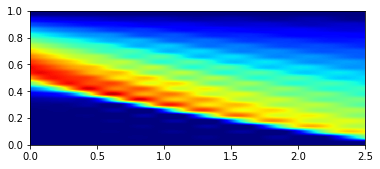

In [10]:
extent=[0,2.5,0,1]
plt.imshow(sol_LES[:,0,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)

# 3) Comparing DNS simulation on the coarse grid to the LES simulation

In [11]:
# here we compute 2 versions of the coarse DNS solutions, one simply subsampled and the otherone 
# box filtered filtered at the resolution 
sol_DNS_LR_Fil = Burgers_Torch.filterDown(sol_DNS[:,:,:],int(nx/nxLES))
sol_DNS_LR_SS  = sol_DNS[:,:,::scale]
sol_DNS_LR_SS[:,:,0] = sol_DNS_LR_SS[:,:,-1] = 0

Text(0.5, 1.0, 'LES solution')

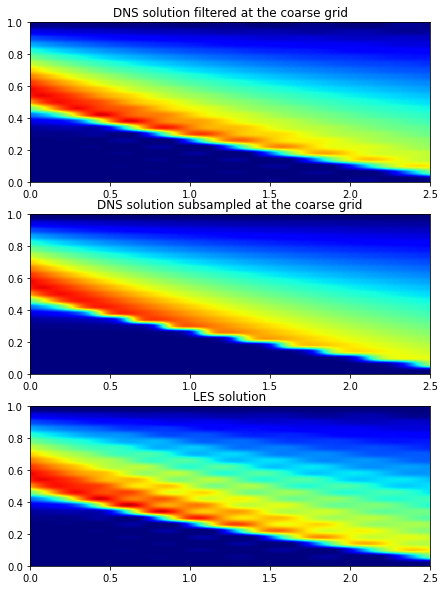

In [12]:
fig, axs = plt.subplots(3,figsize = (10,10))
axs[0].imshow(sol_DNS_LR_Fil[:,0,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)
axs[0].set_title('DNS solution filtered at the coarse grid')
axs[1].imshow(sol_DNS_LR_SS[:,0,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)
axs[1].set_title('DNS solution subsampled at the coarse grid')
axs[2].imshow(sol_LES[:,0,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)
axs[2].set_title('LES solution')

# 4) LES simulation with a subgrid closure term

In [13]:
# here the model is in python (not differentiable) since it will not be used in the project for training its just a benshmark
def burg_system(u,t,dx,visc,sgs = False):
    # compute derivatives
    u[0] = u[-1] = 0.
    derivs = utils.derivative(u,dx)
    du2dx  = derivs['du2dx']
    d2udx2 = derivs['d2udx2'] 
    du2dx[0] = du2dx[-1] = 0.
    d2udx2[0] = d2udx2[-1] = 0.
    # add fractional Brownian motion (FBM) noise
    #fbm = utils.noise(0.75,nx)
    if sgs:
        kr     = 0
        dudx   = derivs['dudx']
        sgs    = LES.subgrid(u,dudx,dx,kr)
        tau    = sgs["tau"]
        coeff  = sgs["coeff"]
        dtaudx = utils.derivative(tau,dx)["dudx"]
        sgst   = - 0.5*dtaudx
        sgst[0] = sgst[-1] = 0.
    else:
        sgst   = 0
    # compute right hand side
    rhs = visc * d2udx2 - 0.5*du2dx + sgst#+ np.sqrt(2*damp/dt)*fbm
    return rhs

In [14]:
from burgers import Utils, BurgersLES
utils    = Utils()
LES      = BurgersLES(1)#1 : Constant-coefficient Smagorinsky
sol_LES2 = []
for i in range(inituLES.shape[0]):
    sol_LES2.append(odeint(burg_system, inituLES[i,:], Time_sampling, args=(dxLES,visc,True,), mxstep=5000))
sol_LES2 = (np.swapaxes(np.array(sol_LES2),0,1))

[pyBurgers: SGS] 	 Constant-coefficient Smagorinsky


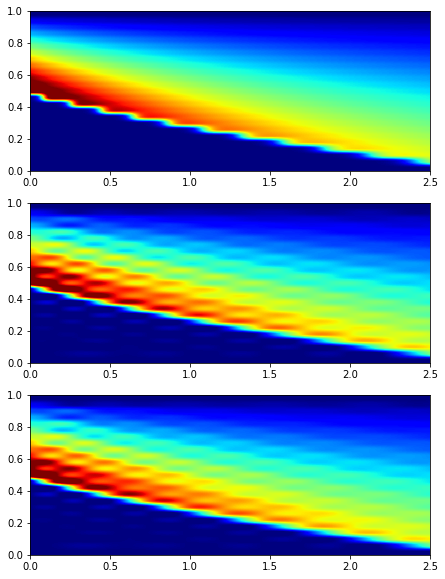

In [15]:
fig, axs = plt.subplots(3,figsize = (10,10))
axs[0].imshow(sol_DNS_LR_SS[:,-1,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)
axs[1].imshow(sol_LES[:,-1,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)
axs[2].imshow(sol_LES2[:,-1,:].T,cmap = 'jet',extent=extent,vmin = 0, vmax = 0.4)

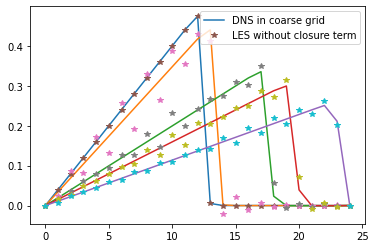

In [16]:
idx = -1

plt.plot(sol_DNS_LR_SS[0,idx,:], label = 'DNS in coarse grid')
plt.plot(sol_DNS_LR_SS[150,idx,:])
plt.plot(sol_DNS_LR_SS[1000,idx,:])
plt.plot(sol_DNS_LR_SS[1500,idx,:])
plt.plot(sol_DNS_LR_SS[-1,idx,:])

plt.plot(sol_LES[0,idx,:],'*', label = 'LES without closure term')
plt.plot(sol_LES[150,idx,:],'*')
plt.plot(sol_LES[1000,idx,:],'*')
plt.plot(sol_LES[1500,idx,:],'*')
plt.plot(sol_LES[-1,idx,:],'*')
plt.legend()

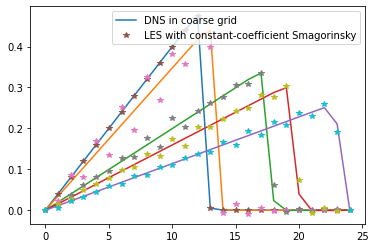

In [17]:
idx = -1

plt.plot(sol_DNS_LR_SS[0,idx,:], label = 'DNS in coarse grid')
plt.plot(sol_DNS_LR_SS[150,idx,:])
plt.plot(sol_DNS_LR_SS[1000,idx,:])
plt.plot(sol_DNS_LR_SS[1500,idx,:])
plt.plot(sol_DNS_LR_SS[-1,idx,:])

plt.plot(sol_LES2[0,idx,:],'*', label = 'LES with constant-coefficient Smagorinsky')
plt.plot(sol_LES2[150,idx,:],'*')
plt.plot(sol_LES2[1000,idx,:],'*')
plt.plot(sol_LES2[1500,idx,:],'*')
plt.plot(sol_LES2[-1,idx,:],'*')
plt.legend()

# 5) Neural closure : Build a model that replaces the sgst term in the burgers equation